In [ ]:
with open("svante.txt") as f:
    text = f.read()
svante = text.split(" ")

with open("arctic.txt") as f:
    text = f.read()
arctic = text.split(" ")

In [ ]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [139]:

def create_embeddings(chunk: list[str]):
    embeddings = client.embeddings.create(input = chunk, model = "text-embedding-3-large", dimensions=256, timeout=5)
    return [d.embedding for d in embeddings.data]

def create_chunks(lst, num_chunks):
    return [lst[i:i + num_chunks] for i in range(0, len(lst), num_chunks)]

# Run embedding on multiple threads using multiprocessing
def create_embedding_parallel(chunks: list[str], num_threads=4):
    import multiprocessing
    from concurrent.futures import ThreadPoolExecutor
    # Split chinks into N lists of chunks
    chunks_of_chunks = create_chunks(chunks, num_threads)
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        embeddings = list(executor.map(create_embeddings, chunks_of_chunks))
    # Now we have a list of list of embeddings. Flatten out
    all_embeddings = []
    for e in embeddings:
        all_embeddings.extend(e)
    return all_embeddings
# svante_sentences = ' '.join(svante).split('.')
# import time
# start = time.time()
# embeddings = create_embedding_parallel(svante_sentences, num_threads=1)
# end = time.time()
# print("Done after ", end-start)
# print(len(embeddings), ' vs ', len(svante_sentences))
    

In [140]:
from tqdm import tqdm

def create_all_embeddings(words):        
    chunk_size = 25
    chunk_stride = 5
    # Split words into chunks of size chunk_size and stride chunk_stride
    chunks = [words[i:i+chunk_size] for i in range(0, len(words), chunk_stride)]

    # Loop over all chunks and generate embeddings
    embeddings = []
    chunks_as_str = [" ".join(chunk) for chunk in chunks]
    embeddings = create_embedding_parallel(chunks_as_str, num_threads=10)
    # for chunk in tqdm(chunks):
    #     chunk_as_str = " ".join(chunk)
    #     embedding = client.embeddings.create(input = chunk_as_str, model = "text-embedding-3-large", dimensions=256, timeout=5)
    #     embeddings.append(embedding.data[0].embedding)
    return chunks, embeddings

In [142]:
chunks, embeddings = create_all_embeddings(svante)

In [143]:
import numpy as np
def autocorr(embeddings):
    corr_values = np.zeros(len(embeddings))
    counts = np.zeros(len(embeddings))
    for i in range(len(embeddings)):
        for j in range(i, len(embeddings)):
            corr_values[j-i] += np.dot(embeddings[i], embeddings[j])
            counts[j-i] += 1

    corr_values /= counts
    return corr_values

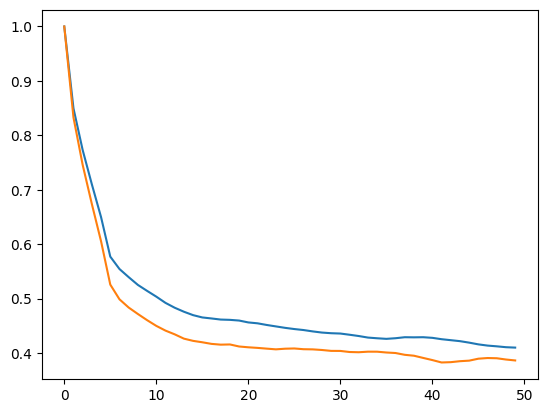

In [144]:
svante_chunks, svante_embeddings = create_all_embeddings(svante)
svante_corr = autocorr(svante_embeddings)

import matplotlib.pyplot as plt
arctic_chunks, arctic_embeddings = create_all_embeddings(arctic)
arctic_corr = autocorr(arctic_embeddings)

plt.plot(arctic_corr[0:50], label='arctic')
plt.plot(svante_corr[0:50], label='svante')
plt.legend()
